### Install partial_CCA if not done before

In [1]:
pip install partial_CCA

Looking in indexes: https://test.pypi.org/simple/Note: you may need to restart the kernel to use updated packages.



## Load necessary libraries and define some helpful functions

In [19]:
import os
import numpy as np
import pandas as pd
from pynwb import NWBHDF5IO
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import scipy

def get_spike_matrix(spike_times, start, stop, srate, srate_resample):
    num_units = spike_times.shape[0]
    
    # 1. Replicate your original 'time' calculation exactly
    # Original: time = (stop*srate)-(start*srate)
    total_high_res_samples = int((stop * srate) - (start * srate)) + 1
    new_bin = int(srate / srate_resample)
    
    # Calculate the number of resampled bins exactly like your reshape logic:
    # int(multi_units.shape[1] / new_bin)
    num_resampled_bins = int(total_high_res_samples / new_bin)
    
    sum_units = np.zeros((num_units, num_resampled_bins), dtype=np.float16)

    for x in range(num_units):
        # Filter spikes exactly as before
        spikes = spike_times[x]
        spikes_maze = spikes[(spikes >= start) & (spikes < stop)]
        
        # Convert to high-res indices exactly as before
        s_unit = (spikes_maze * srate - start * srate).astype(np.int64)
        
        # Filter indices that would be cut off by your original reshape:
        # multi_units[:, 0 : int(multi_units.shape[1]/new_bin) * new_bin]
        valid_limit = num_resampled_bins * new_bin
        s_unit = s_unit[s_unit < valid_limit]
        
        # This is the "Magic Trick": 
        # Integer division by 'new_bin' maps the high-res index directly 
        # to the downsampled bin index. 
        resampled_indices = s_unit // new_bin
        
        # Count occurrences in each resampled bin
        counts = np.bincount(resampled_indices, minlength=num_resampled_bins)
        sum_units[x, :] = counts.astype(np.float16)

    # --- Convolution part (Unaltered) ---
    kernel = signal.windows.gaussian(int(0.2*srate_resample), srate_resample/400)
    
    conv_neurons = []
    for x in range(sum_units.shape[0]):
        conv = signal.convolve(np.squeeze(
            sum_units[x, :]), kernel, mode='same')
        conv = conv*srate_resample/np.sum(kernel)
        conv_neurons.append(conv)
    conv_neurons = np.array(conv_neurons)
    
    return conv_neurons, sum_units

# --- Handle constant rows BEFORE z-scoring ---
def remove_constant_rows(data):
    """Removes rows with zero standard deviation from a 2D numpy array."""
    stds = np.std(data, axis=1)
    non_constant_rows = stds > 0
    return data[non_constant_rows, :], non_constant_rows # return filtered data and boolean mask

## Load NWB data from local storage
### If you want to load straight from DANDI server un-mark the next cell 

In [76]:
# Change the current working directory to the folder containing the NWB file.
# Note: This path is specific to the original user's machine and may need to be updated.

file_name = 'sub-M02_ses-20240314T100000_behavior+ecephys.nwb'
os.chdir(r'C:\Users\GONZAJ81\Desktop\DANDI set\001695\sub-M02')

from pynwb import NWBHDF5IO
io = NWBHDF5IO(file_name, 'r')
nwbfile = io.read()

# Access the 'units' table from the NWB file, which contains spike data and metadata for each neuron.
units_table = nwbfile.units
# Extract the spike times for all recorded units.
spike_times = units_table['spike_times']
# Extract the classified cell type for each unit and convert it to a numpy array.
cell_type = np.array(units_table['cell_type'])
# Extract the brain region (anatomical area) for each unit and convert it to a numpy array.
cell_area = np.array(units_table['cell_area'])

# Filter the spike times to isolate only those neurons located in each brain region.
spike_times_ca1 = spike_times[(cell_type == 'Pyramidal Cell') * (cell_area == "CA1")]
spike_times_ca3 = spike_times[(cell_type == 'Pyramidal Cell') * (cell_area == "CA3")]
spike_times_rsc = spike_times[(cell_type != 'Narrow Interneuron') * (cell_area == "RSC")]

# Access 'behavior' from the NWB file
behavior_module = nwbfile.processing['behavior']

# Extract the 2D position data (x, y coordinates) from the 'Position' spatial series and convert to a numpy array.
position = np.array(behavior_module['AnimalPosition']['Position'].data)

# Extract the speed data from the 'Speed' timeseries and convert to a numpy array.
speed = np.array(behavior_module['Speed'].data)

# Extract the timestamps corresponding to each position/speed data point.
timestamps = np.array(behavior_module['AnimalPosition']['Position'].timestamps)


### Change this cell to code if you want to directly load recordings from DANDI

dandiset_id = '001695'
filepath = 'sub-M02/sub-M02_ses-20240314T100000_behavior+ecephys.nwb'

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

r_file = remfile.File(s3_url)
h5_file = h5py.File(r_file, 'r')

with NWBHDF5IO(file=h5_file, mode='r', load_namespaces=True) as io:
    nwbfile = io.read()

    # We use a list comprehension but call .tolist() or direct index
    # to ensure we get the data out before the file closes
    num_units = len(nwbfile.units)

    print("Streaming data...")
    # Using 'get_unit_spike_times' is the safest way to access the ragged arrays
    # while the file handle is open.

    cell_areas = nwbfile.units['cell_area'][:]
    cell_types = nwbfile.units['cell_type'][:]

    # Filter for area
    ca1_indices = np.where((cell_types == 'Pyramidal Cell') * (cell_areas == "CA1"))[0]
    ca3_indices = np.where((cell_types == 'Pyramidal Cell') * (cell_areas == "CA3"))[0]
    rsc_indices = np.where((cell_types != 'Narrow Interneuron') * (cell_areas == "RSC"))[0]
    

    spike_times_ca1 = [nwbfile.units.get_unit_spike_times(i) for i in ca1_indices]
    spike_times_ca3 = [nwbfile.units.get_unit_spike_times(i) for i in ca3_indices]
    spike_times_rsc = [nwbfile.units.get_unit_spike_times(i) for i in rsc_indices]


    # Extract behavior
    behavior_module = nwbfile.processing['behavior']

    # Extract the 2D position data (x, y coordinates) from the 'Position' spatial series and convert to a numpy array.
    position = np.array(behavior_module['AnimalPosition']['Position'].data)

    # Extract the speed data from the 'Speed' timeseries and convert to a numpy array.
    speed = np.array(behavior_module['Speed'].data)

    # Extract the timestamps corresponding to each position/speed data point.
    timestamps = np.array(behavior_module['AnimalPosition']['Position'].timestamps)

    # Extract Sleep
    # Access the 'SleepStates' interval table from the NWB file.
    sleep_states = nwbfile.intervals['SleepStates']

    # Extract the array of state labels ('WAKE', 'NREM', 'REM') and times into numpy arrays.
    states = np.array(sleep_states['state'])
    start_time = np.array(sleep_states['start_time'])
    stop_time = np.array(sleep_states['stop_time'])
    nrem_index = states == 'NREM'
    rem_index = states == 'REM'
    wake_index = states == 'WAKE'


print(f"Successfully retrieved data!")

## Generate the spiking matrix and filter for running speed

In [78]:
# get maze runs
start = timestamps[0]
stop = timestamps[-1]

srate_resample = 1250

spike_times_ca1 = np.array(spike_times_ca1,dtype = 'object')
spike_times_ca3 = np.array(spike_times_ca3,dtype = 'object')
spike_times_rsc = np.array(spike_times_rsc,dtype = 'object')

# get convolved spike matrix

conv_neurons_ca1, _ = get_spike_matrix(spike_times_ca1, start, stop, srate = 30000, srate_resample = srate_resample)
conv_neurons_ca3, _ = get_spike_matrix(spike_times_ca3, start, stop, srate = 30000, srate_resample = srate_resample)
conv_neurons_rsc, _ = get_spike_matrix(spike_times_rsc, start, stop, srate = 30000, srate_resample = srate_resample)

# only use speed times > 2.5cm/s
srate_video = 25
speed_maze_repeat = np.repeat(speed,int(srate_resample/srate_video))
linearized_position_repeat = np.repeat(position,int(srate_resample/srate_video))
speed_times = speed_maze_repeat>2.5

speed_times_size = speed_times.shape[0]

if speed_times_size<conv_neurons_ca1.shape[1]:
    
    conv_neurons_ca1 = conv_neurons_ca1[:,0:speed_times_size]
    conv_neurons_ca3 = conv_neurons_ca3[:,0:speed_times_size]
    conv_neurons_rsc = conv_neurons_rsc[:,0:speed_times_size]
    
    
if speed_times_size>conv_neurons_ca1.shape[1]:
    
    speed_times = speed_times[0:conv_neurons_ca1.shape[1]]
    linearized_position_repeat = linearized_position_repeat[0:conv_neurons_ca1.shape[1]]
    
conv_neurons_ca1_speed = conv_neurons_ca1[:,speed_times.squeeze()]
conv_neurons_ca3_speed = conv_neurons_ca3[:,speed_times.squeeze()]
conv_neurons_rsc_speed = conv_neurons_rsc[:,speed_times.squeeze()]


# do subspace analysis

# --- Handle constant rows BEFORE z-scoring ---
def remove_constant_rows(data):
    """Removes rows with zero standard deviation from a 2D numpy array."""
    stds = np.std(data, axis=1)
    non_constant_rows = stds > 0
    return data[non_constant_rows, :], non_constant_rows # return filtered data and boolean mask

conv_neurons_ca1_speed, mask_ca1 = remove_constant_rows(conv_neurons_ca1_speed)
conv_neurons_ca3_speed, mask_ca3 = remove_constant_rows(conv_neurons_ca3_speed)
conv_neurons_rsc_speed, mask_rsc = remove_constant_rows(conv_neurons_rsc_speed)

# --- Now perform z-scoring AFTER removing constant rows ---
conv_neurons_ca1_speed = stats.zscore(conv_neurons_ca1_speed,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
conv_neurons_ca3_speed = stats.zscore(conv_neurons_ca3_speed,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
conv_neurons_rsc_speed = stats.zscore(conv_neurons_rsc_speed,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness

## Subspace analysis with partial_CCA
### Compute CA1-CA3 subspace 

In [79]:
from partial_CCA import PartialCCA

# fit pCCA
ca1_ca3_pCCA = PartialCCA()
ca1_ca3_pCCA.fit(conv_neurons_ca1_speed.T,conv_neurons_ca3_speed.T,conv_neurons_rsc_speed.T)

# get correlations
correlations_ca1_ca3 = ca1_ca3_pCCA.canonical_correlations_

# Access weights
ca1_weights_ca1_ca3 = ca1_ca3_pCCA.weights_x_
ca3_weights_ca1_ca3 = ca1_ca3_pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
ca1_ca3_p_values,ca1_ca3_r_surr = ca1_ca3_pCCA.surrogate_test(conv_neurons_ca1_speed.T,conv_neurons_ca3_speed.T,conv_neurons_rsc_speed.T)

### Plot subspace correlation and dimensionality

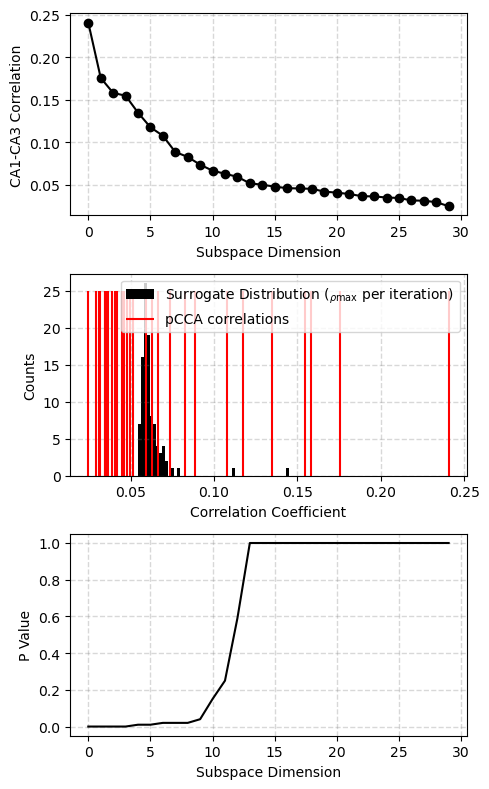

In [80]:
plt.figure(figsize = (5,8))

plt.subplot(311)
plt.plot(correlations_ca1_ca3,'-o', color = 'black')
plt.ylabel('CA1-CA3 Correlation')
plt.xlabel('Subspace Dimension')
#plt.ylim([-0.1,1])
#plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(312)
plt.hist(ca1_ca3_r_surr, color='black', bins = 50, label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.vlines(correlations_ca1_ca3,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(313)
plt.plot(ca1_ca3_p_values, color='black')
plt.xlabel('Subspace Dimension')
plt.ylabel('P Value')
#plt.hlines(0,len(ca1_ca3_p_values),0.05, color = 'red')
#plt.yscale('log')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()

### Compute CA1-RSC subspace

In [81]:
# fit pCCA
ca1_rsc_pCCA = PartialCCA()
ca1_rsc_pCCA.fit(conv_neurons_ca1_speed.T,conv_neurons_rsc_speed.T,conv_neurons_ca3_speed.T)

# get correlations
correlations_ca1_rsc = ca1_rsc_pCCA.canonical_correlations_

# Access weights
ca1_weights_ca1_rsc = ca1_rsc_pCCA.weights_x_
rsc_weights_ca1_rsc = ca1_rsc_pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
ca1_rsc_p_values,ca1_rsc_r_surr = ca1_rsc_pCCA.surrogate_test(conv_neurons_ca1_speed.T,conv_neurons_rsc_speed.T,conv_neurons_ca3_speed.T)

### Plot subspace correlation and dimensionality

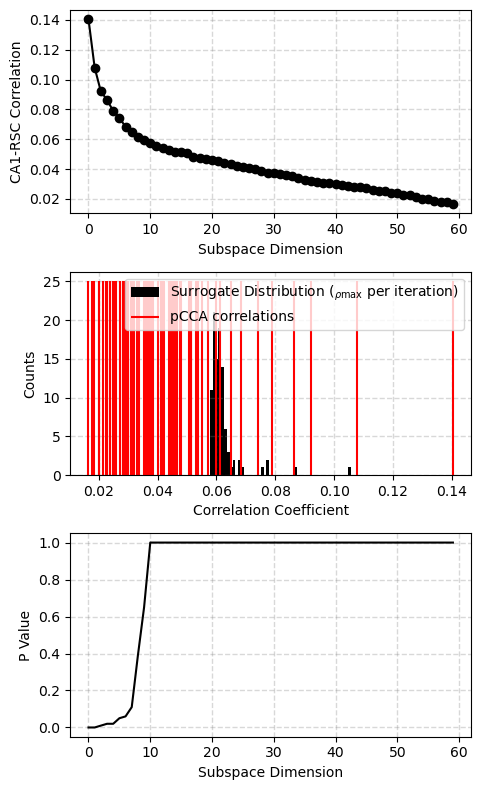

In [83]:
plt.figure(figsize = (5,8))

plt.subplot(311)
plt.plot(correlations_ca1_rsc,'-o', color = 'black')
plt.ylabel('CA1-RSC Correlation')
plt.xlabel('Subspace Dimension')
#plt.ylim([-0.1,1])
#plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(312)
plt.hist(ca1_rsc_r_surr, color='black', bins = 50, label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.vlines(correlations_ca1_rsc,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(313)
plt.plot(ca1_rsc_p_values, color='black')
plt.xlabel('Subspace Dimension')
plt.ylabel('P Value')
#plt.hlines(0,len(ca1_ca3_p_values),0.05, color = 'red')
#plt.yscale('log')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()

### Compute subspace angles

Text(0.5, 1.0, 'Principal Angles between \nCA1-CA3 and CA1-RSC subspaces')

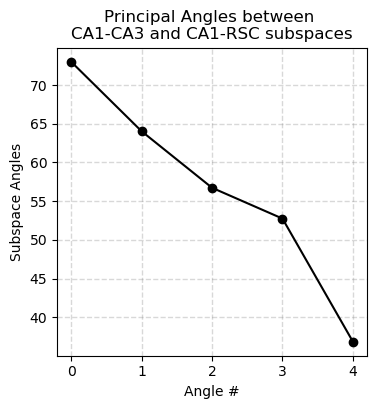

In [92]:
def compute_subspace_angles(weights_x, weights_y):
    
    weights_x = weights_x / np.linalg.norm(weights_x, axis=0, keepdims=True)
    weights_x, _ = scipy.linalg.qr(weights_x, mode='economic')
    
    weights_y = weights_y / np.linalg.norm(weights_y, axis=0, keepdims=True)
    weights_y, _ = scipy.linalg.qr(weights_y, mode='economic')
    
    angles = scipy.linalg.subspace_angles(weights_x, weights_y)

    return(angles)

significant_dims_ca3 = np.sum(np.array(ca1_ca3_p_values)<0.05)
significant_dims_rsc = np.sum(np.array(ca1_rsc_p_values)<0.05)

ca3_rsc_subspace_angles = compute_subspace_angles(ca1_weights_ca1_ca3[:,:significant_dims_ca3],ca1_weights_ca1_rsc[:,:significant_dims_rsc])

plt.figure(figsize = (4,4))
plt.plot(np.rad2deg(ca3_rsc_subspace_angles),'-o', color='black')
plt.ylabel('Subspace Angles')
plt.xlabel('Angle #')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')
plt.title('Principal Angles between \nCA1-CA3 and CA1-RSC subspaces')



### Compute correlation between subspace weight magnitudes

Text(0.5, 1.0, 'R = 0.27, P = 0.0007')

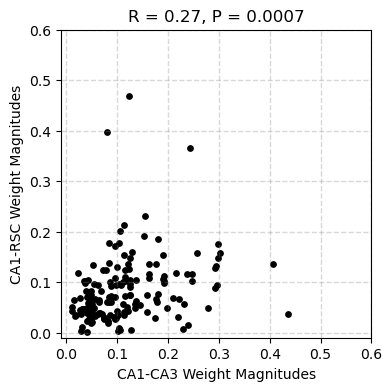

In [104]:
significant_dims_ca3 = np.sum(np.array(ca1_ca3_p_values)<0.05)
significant_dims_rsc = np.sum(np.array(ca1_rsc_p_values)<0.05)

ca1_ca3_weight_magnitude = np.abs(np.max(ca1_weights_ca1_ca3[:,:significant_dims_ca3],axis = 1))
ca1_rsc_weight_magnitude = np.abs(np.max(ca1_weights_ca1_rsc[:,:significant_dims_rsc],axis = 1))

plt.figure(figsize = (4,4))

plt.scatter(ca1_ca3_weight_magnitude,ca1_rsc_weight_magnitude, color = 'black',s = 15)
r, p = stats.pearsonr(ca1_ca3_weight_magnitude,ca1_rsc_weight_magnitude)
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')
plt.xlabel('CA1-CA3 Weight Magnitudes')
plt.ylabel('CA1-RSC Weight Magnitudes')
plt.ylim([-0.01,0.6])
plt.xlim([-0.01,0.6])

plt.title('R = '+str(np.round(r,decimals = 2))+', P = '+str(np.round(p,decimals = 4)))


## Project subspaces during post-maze sleep
### Need to load sleep data 

In [171]:
# Access the 'SleepStates' interval table from the NWB file.
sleep_states = nwbfile.intervals['SleepStates']

# Extract the array of state labels ('WAKE', 'NREM', 'REM') and times into numpy arrays.
states = np.array(sleep_states['state'])
start_time = np.array(sleep_states['start_time'])
stop_time = np.array(sleep_states['stop_time'])
nrem_index = states == 'NREM'
rem_index = states == 'REM'
wake_index = states == 'WAKE'

start_time_nrem = start_time[nrem_index]
stop_time_nrem = stop_time[nrem_index]

# we are just loading the first nrem episode
index = np.where(start_time_nrem>timestamps[-1])[0][0]

start = start_time_nrem[index]
stop = stop_time_nrem[index]

conv_neurons_ca1_nrem, _ = get_spike_matrix(spike_times_ca1, start, stop, srate = 30000, srate_resample = srate_resample)
conv_neurons_ca3_nrem, _ = get_spike_matrix(spike_times_ca3, start, stop, srate = 30000, srate_resample = srate_resample)
conv_neurons_rsc_nrem, _ = get_spike_matrix(spike_times_rsc, start, stop, srate = 30000, srate_resample = srate_resample)

conv_neurons_ca1_nrem = stats.zscore(conv_neurons_ca1_nrem,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
conv_neurons_ca3_nrem = stats.zscore(conv_neurons_ca3_nrem,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
conv_neurons_rsc_nrem = stats.zscore(conv_neurons_rsc_nrem,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness

### Project maze weights using transform method 
### We can also obtain the correlation coefficients using the score method

In [172]:
ca1_ca3_proj_nrem,ca3_proj_nrem = ca1_ca3_pCCA.transform(conv_neurons_ca1_nrem[mask_ca1,:].T,conv_neurons_ca3_nrem[mask_ca3,:].T)
ca1_rsc_proj_nrem,rsc_proj_nrem = ca1_rsc_pCCA.transform(conv_neurons_ca1_nrem[mask_ca1,:].T,conv_neurons_rsc_nrem[mask_rsc,:].T)

correlation_ca3_nrem = ca1_ca3_pCCA.score(conv_neurons_ca1_nrem[mask_ca1,:].T,conv_neurons_ca3_nrem[mask_ca3,:].T)
correlation_rsc_nrem = ca1_rsc_pCCA.score(conv_neurons_ca1_nrem[mask_ca1,:].T,conv_neurons_rsc_nrem[mask_rsc,:].T)

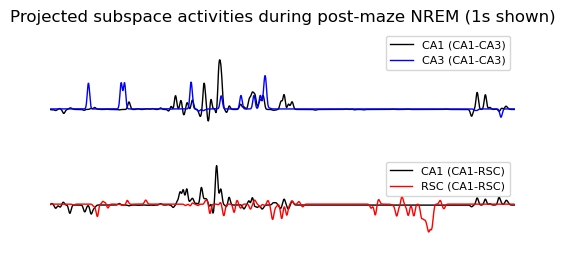

In [175]:
plt.figure(figsize = (6,3))

plt.subplot(211)
plt.plot(ca1_ca3_proj_nrem[0,:],color = 'black', linewidth = 1, label = 'CA1 (CA1-CA3)')
plt.plot(ca3_proj_nrem[0,:],color = 'blue', linewidth = 1, label = 'CA3 (CA1-CA3)')
plt.xlim([10000,11250])
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.title('Projected subspace activities during post-maze NREM (1s shown)')
plt.legend(fontsize = 8)

plt.subplot(212)
plt.plot(ca1_rsc_proj_nrem[0,:],color = 'black', linewidth = 1, label = 'CA1 (CA1-RSC)')
plt.plot(rsc_proj_nrem[0,:],color = 'red', linewidth = 1, label = 'RSC (CA1-RSC)')
plt.xlim([10000,11250])
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize = 8)

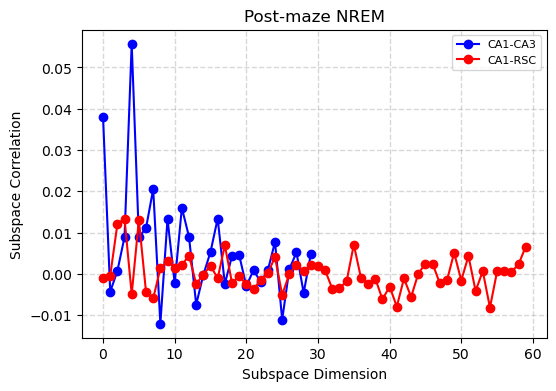

In [179]:
# we are plotting the correlation for all dimensions, but we can also filter by the significant ones
plt.figure(figsize = (6,4))
plt.plot(correlation_ca3_nrem,'-o',color = 'blue', label = 'CA1-CA3')
plt.plot(correlation_rsc_nrem,'-o', color = 'red', label = 'CA1-RSC')
plt.xlabel('Subspace Dimension')
plt.ylabel('Subspace Correlation')
plt.title('Post-maze NREM')
plt.legend(fontsize = 8)
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')